# Code


# Imports

In [23]:
import pandas as pd
from pathlib import Path
import numpy as np
import seaborn as sns
from typing import Tuple
import matplotlib.pyplot as plt

# User Configuration

In [24]:
SAVE_CSV = True  # Save figures
SAVE_FIG = True  # Save figures

AD_FILE = "ad_bootstrap_1000_results.csv"
CV_FILE = "cramersV_bootstrap_1000_results.csv"
KS_FILE = "ks_bootstrap_1000_results.csv"

OUTPUT_DIR_CSV = Path("results")
OUTPUT_DIR_CSV.mkdir(parents=True, exist_ok=True)
OUTPUT_DIR_FIG = Path("figures")
OUTPUT_DIR_FIG.mkdir(parents=True, exist_ok=True)

sns.set_theme(
    style="white",
    context="paper",
    palette="colorblind",
    rc={
        "font.family": "sans-serif",
        "font.sans-serif": ["Arial"],
        # "font.size": 7,
        # "axes.titlesize": 7,
        # "axes.labelsize": 7,
        # "xtick.labelsize": 7,
        # "ytick.labelsize": 7,
        # "legend.fontsize": 7
    }
)

# Utility Functions
## Simultane Bootstrap-CIs

In [25]:
def calc_featurewise_ci_fwer(
    df_results: pd.DataFrame,
    delta: float = 0.05,          # Äquivalenzgrenze
    alpha_global: float = 0.05,   # gewünschtes family-wise α
    title: str = "ks_stat"
):
    m = df_results.shape[1]                 # Zahl der parallelen Features
    alpha_local = alpha_global / m          # Bonferroni-Teilung
    lo_p  = 100 * (alpha_local / 2)         # z. B. 0.125 %
    hi_p  = 100 * (1 - alpha_local / 2)     # z. B. 99.875 %

    # --------------------------------------------------------
    # 1) simultane CIs + Mittelwerte berechnen
    # --------------------------------------------------------
    summary = []
    for feat, vals in df_results.items():
        lower = np.percentile(vals, lo_p)
        upper = np.percentile(vals, hi_p)
        mean_ = vals.mean()
        summary.append(
            dict(feature=feat,
                 mean_stat=mean_,
                 ci_lower=lower,
                 ci_upper=upper,
                 equiv = upper < delta)     # Entscheidung
        )
    df_sum = pd.DataFrame(summary)

    # Fehlerbalken für Matplotlib
    df_sum["err_low"]  = df_sum["mean_stat"] - df_sum["ci_lower"]
    df_sum["err_high"] = df_sum["ci_upper"] - df_sum["mean_stat"]
    df_sum["data"] = title
    return df_sum

## Plotting Function

In [44]:
def plot_featurewise_ci_fwer(
    ax: plt.Axes,
    df_sum: pd.DataFrame,
    delta: float = 0.05,          # Equivalence threshold
    alpha_global: float = 0.05,   # Desired family-wise α
    title: str = "KS statistic",
    leg_pos: str = "upper right",
):

    # Color assignment: equivalent = blue, not equivalent = orange
    palette_cb = sns.color_palette("colorblind", 2)
    colors = df_sum["equiv"].map({True: palette_cb[0], False: palette_cb[1]})

    # Points
    ax.scatter(x=df_sum.index,
               y=df_sum["mean_stat"],
               c=colors,
               s=90,
               zorder=3)

    # Error bars (asymmetric)
    for idx, row in df_sum.iterrows():
        ax.errorbar(x=idx,
                    y=row["mean_stat"],
                    yerr=[[row["err_low"]], [row["err_high"]]],
                    fmt="none",
                    ecolor=colors.iloc[idx],
                    elinewidth=1.5,
                    capsize=4,
                    zorder=2)

    # Threshold δ
    ax.axhline(delta, color="grey", ls="--", lw=1, label=f"δ = {delta}", zorder=1)

    # Axis styling
    ax.set_xticks(df_sum.index)
    ax.set_xticklabels(df_sum["feature"], rotation=45, ha="right")
    # ax.set_ylabel(title)
    # ax.set_xlabel("Feature")
    # ax.set_title(f"{title}: simultaneous {(1-alpha_global):.0%} CIs (Bonferroni-corrected)")
    ax.set_title(f"{title}")
    ax.grid(axis="y", ls="--", alpha=0.5)

    # Legend
    from matplotlib.patches import Patch
    handles = [Patch(color=palette_cb[0], label="Equiv. (CI < δ)"),
               Patch(color=palette_cb[1], label="Not equiv."),
               ax.lines[-1]]        # δ line
    # ax.legend(handles=handles, loc=leg_pos)
    ax.legend(handles=handles)

    plt.tight_layout()

    return ax, df_sum            # df_sum contains the full table


# Main Routine
## Daten Laden

In [27]:
ad = pd.read_csv(OUTPUT_DIR_CSV / AD_FILE, decimal=",", sep=";", encoding="utf-8")
cv = pd.read_csv(OUTPUT_DIR_CSV / CV_FILE, decimal=",", sep=";", encoding="utf-8")
ks = pd.read_csv(OUTPUT_DIR_CSV / KS_FILE, decimal=",", sep=";", encoding="utf-8")

In [28]:
ad_wide = ad.copy()
ad_wide['run_id'] = ad_wide.index

ad_long = ad_wide.melt(
    id_vars='run_id',
    var_name='feature',
    value_name='ad_stat'
)

ad_long['feature'] = ad_long['feature'].str.replace('_stat', '', regex=False)

In [29]:
cv_df = cv.filter(like='_V')
cv_wide = cv_df.copy()
cv_wide['run_id'] = cv_df.index

cv_long = cv_wide.melt(
    id_vars='run_id',
    var_name='feature',
    value_name='cv_stat'
)

cv_long['feature'] = cv_long['feature'].str.replace('_V', '', regex=False)

In [30]:
ks_wide = ks.copy()
ks_wide['run_id'] = ks_wide.index

ks_long = ks_wide.melt(
    id_vars='run_id',
    var_name='feature',
    value_name='ks_stat'
)

## KS

In [31]:
ks_sum = calc_featurewise_ci_fwer(
    df_results   = ks_long.pivot(index="run_id", columns="feature", values="ks_stat"),
    delta        = 0.05,
    alpha_global = 0.05,
    title = "ks_stat"
)
# ks.to_csv(OUTPUT_DIR_CSV / f"ks_new.csv", sep=";", decimal=",", index=False)

## CV

In [32]:
cv_sum = calc_featurewise_ci_fwer(
    df_results   = cv_long.pivot(index="run_id", columns="feature", values="cv_stat"),
    delta        = 0.05,
    alpha_global = 0.05,
    title= "cv_stat"
)
# cv_sum.to_csv(OUTPUT_DIR_CSV / f"cv_new.csv", sep=";", decimal=",", index=False)



## AD

In [33]:
ad_sum = calc_featurewise_ci_fwer(
    df_results   = ad_long.pivot(index="run_id", columns="feature", values="ad_stat"),
    delta        = 25,
    alpha_global = 0.05,
    title= "ad_stat"
)
# ad_sum.to_csv(OUTPUT_DIR_CSV / f"ad_new.csv", sep=";", decimal=",", index=False)

## Combination

In [34]:
def load_summary(df: pd.DataFrame, stat_label: str) -> pd.DataFrame:
    """
    Lädt eine Bootstrap-Zusammenfassung und bereitet sie auf.
    Erwartet CSV ohne Header, Semikolon-separiert, mit Zeile 1 als Header.
    """
    # Überspringe die erste Zeile (evtl. doppelter Header) und lese rest
    df.columns = ["feature", "mean_stat", "ci_lower", "ci_upper", "equiv", "err_low", "err_high", "stat_type"]
    # Numerische Spalten umwandeln
    for col in ["mean_stat", "ci_lower", "ci_upper", "err_low", "err_high"]:
        df[col] = df[col].astype(str).str.replace(",", ".").str.replace(" ", "").astype(float)
    df["equiv"] = df["equiv"].astype(str).str.lower() == "true"
    df["stat"] = stat_label
    return df

# Lade alle drei Statistiken
ks_df = load_summary(ks_sum, "KS")
cv_df = load_summary(cv_sum, "CV")
ad_df = load_summary(ad_sum, "AD")


In [35]:
combined = pd.concat([ks_df, cv_df, ad_df], ignore_index=True)
combined.loc[combined['feature'].str.endswith('_TVD'), 'stat'] = 'TVD'
combined['feature'] = combined['feature'].str.replace('_TVD', '', regex=False).str.replace('_KS', '', regex=False)

# Plotting
## KS

In [36]:
ks_isolated = combined[combined["stat"] == "KS"].reset_index(drop=True)
tvd_isolated = combined[combined["stat"] == "TVD"].reset_index(drop=True)
cv_isolated = combined[combined["stat"] == "CV"].reset_index(drop=True)
ad_isolated = combined[combined["stat"] == "AD"].reset_index(drop=True)

In [ ]:
data_list = [ks_isolated, ad_isolated, tvd_isolated, cv_isolated]
titles = ["Kolmogorov-Smirnov", "Anderson-Darling", "Total Variation Distance", "Cramér's V"]
deltas = [0.05, 25, 0.05, 0.05]
alphas = [0.05, 0.05, 0.05, 0.05]

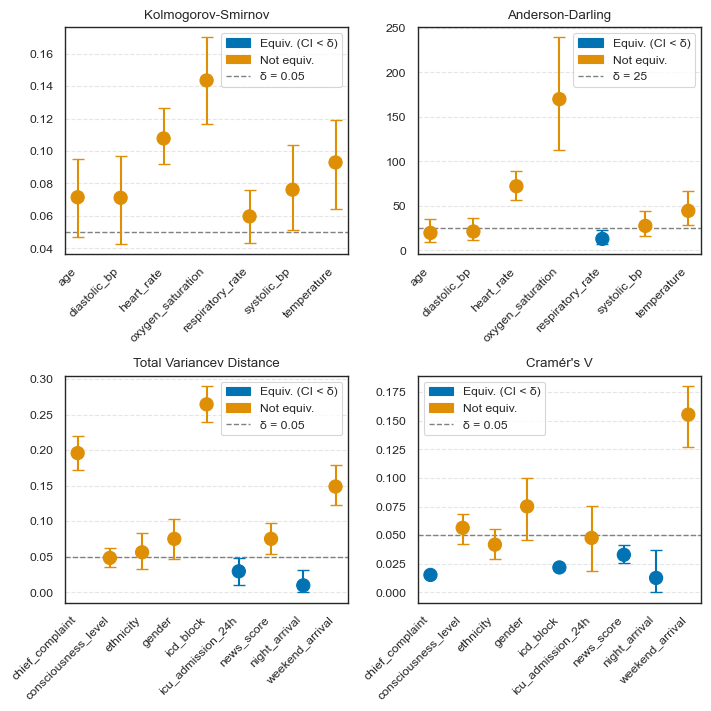

In [49]:
fig, axs = plt.subplots(2, 2, figsize=(7.2, 7.2))

# Plotten
for i, ax in enumerate(axs.flat):
    plot_featurewise_ci_fwer(
        ax=ax,
        df_sum=data_list[i],
        delta=deltas[i],
        alpha_global=alphas[i],
        title=titles[i]
    )

plt.tight_layout()
plt.show()
if SAVE_FIG:
    fig.savefig(OUTPUT_DIR_FIG / f"hypothesis_tests.tiff", dpi=300, format='tiff', bbox_inches='tight', pil_kwargs={'compression': 'tiff_lzw'})
plt.close(fig)

# --- ALte Logik
## KS

In [ ]:
# ks_isolated = combined[combined["stat"] == "KS"].reset_index(drop=True)
# fig, ax, tbl = plot_featurewise_ci_fwer(
#     df_sum       = ks_isolated,
#     delta        = 0.05,
#     alpha_global = 0.05,
#     title        = "KS_statistic",
#     figsize      = (1.8, 2)
# )

## TVD

In [ ]:
# tvd_isolated = combined[combined["stat"] == "TVD"].reset_index(drop=True)
# fig, ax, tbl = plot_featurewise_ci_fwer(
#     df_sum       = tvd_isolated,
#     delta        = 0.05,
#     alpha_global = 0.05,
#     title        = "TVD_statistic",
#     figsize      = (1.8, 2)
# )

## CV

In [ ]:
# cv_isolated = combined[combined["stat"] == "CV"].reset_index(drop=True)
# fig, ax, tbl = plot_featurewise_ci_fwer(
#     df_sum       = cv_isolated,
#     delta        = 0.05,
#     alpha_global = 0.05,
#     title        = "CV statistic",
#     figsize      = (4, 4.5),
#     leg_pos = "upper left"
# )

## AD

In [ ]:
# ad_isolated = combined[combined["stat"] == "AD"].reset_index(drop=True)
# fig, ax, tbl = plot_featurewise_ci_fwer(
#     df_sum       = ad_isolated,
#     delta        = 25,
#     alpha_global = 0.05,
#     title        = "AD_statistic",
#     figsize      = (3.5, 4)
# )